Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
#Developed by Rohinee Kanta Mishra#
!pip install tensorflow==2.13.1

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive')

## Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
import zipfile
import pathlib
import os

# Define the path to the zip file

zip_extract_dir = '/content/drive/MyDrive/CNN1/'

# Extract the zip file if it hasn't been extracted already
#if not os.path.exists(zip_extract_dir):
#  with zipfile.ZipFile(root_path, 'r') as zip_ref:
#       zip_ref.extractall(zip_extract_dir)

# Define the paths to the train and test data directories
data_dir_train = pathlib.Path(zip_extract_dir+'Train')
data_dir_test = pathlib.Path(zip_extract_dir+'Test')

# Check if the directories exist
print(f"Training data path: {data_dir_train}")
print(f"Testing data path: {data_dir_test}")
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

Training data path: /content/drive/MyDrive/CNN1/Train
Testing data path: /content/drive/MyDrive/CNN1/Test
2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

This assignment uses a dataset of about 2239 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.


### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)


['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

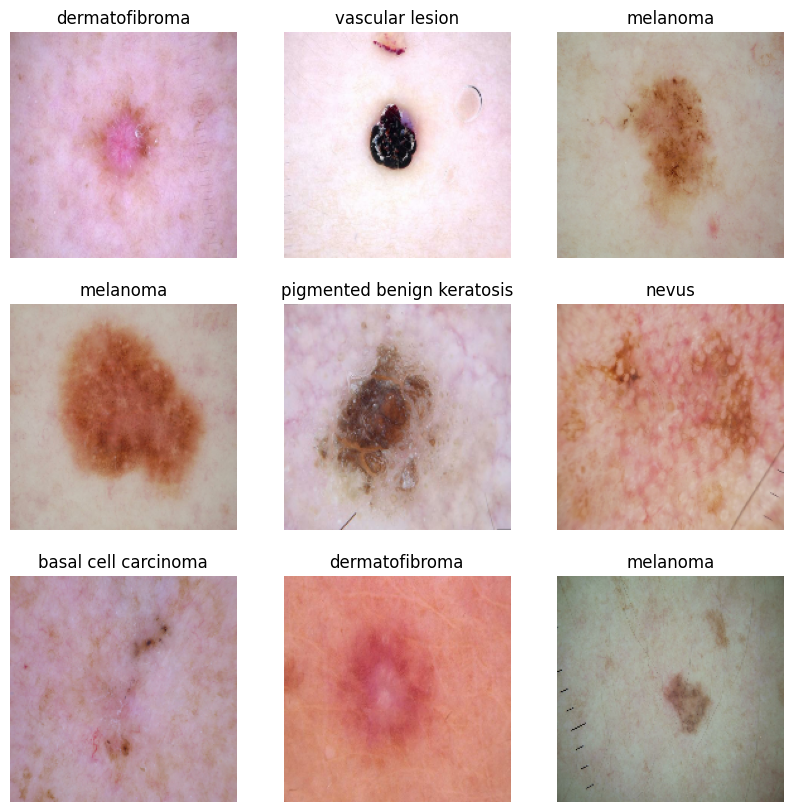

In [ ]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Your code goes here

# Number of target labels are 9
target_labels = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

In [ ]:
# Before compiling the model
# Assuming your original labels start from 1
# Adjust this if your labels start from a different value

def adjust_labels(image, label):

    adjusted_label = tf.clip_by_value(label - 1, 0, target_labels - 1)
    return image, adjusted_label

train_ds = train_ds.map(adjust_labels)
val_ds = val_ds.map(adjust_labels)



### Todo, choose an appropriate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [ ]:
%%time
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
169/169 [==============================] - 1337s 3s/step - loss: 1.8857 - accuracy: 0.2830 - val_loss: 1.6829 - val_accuracy: 0.3860
Epoch 2/10
169/169 [==============================] - 200s 1s/step - loss: 1.3784 - accuracy: 0.4789 - val_loss: 1.2271 - val_accuracy: 0.5405
Epoch 3/10
169/169 [==============================] - 207s 1s/step - loss: 1.2338 - accuracy: 0.5300 - val_loss: 1.2170 - val_accuracy: 0.5471
Epoch 4/10
169/169 [==============================] - 212s 1s/step - loss: 1.0957 - accuracy: 0.5820 - val_loss: 1.1466 - val_accuracy: 0.5798
Epoch 5/10
169/169 [==============================] - 210s 1s/step - loss: 0.9715 - accuracy: 0.6346 - val_loss: 0.9610 - val_accuracy: 0.6526
Epoch 6/10
169/169 [==============================] - 210s 1s/step - loss: 0.8400 - accuracy: 0.6949 - val_loss: 0.9219 - val_accuracy: 0.6793
Epoch 7/10
169/169 [==============================] - 203s 1s/step - loss: 0.7118 - accuracy: 0.7428 - val_loss: 1.0013 - val_accuracy: 0.687

### Visualizing training results

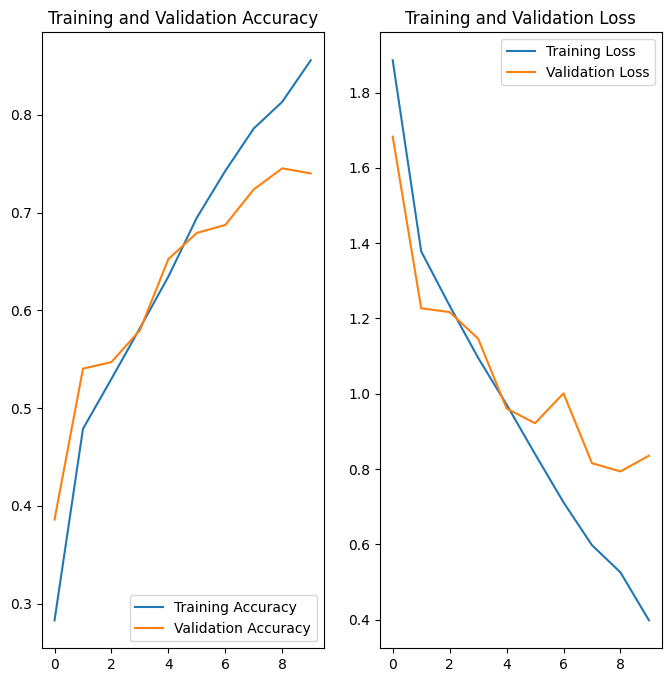

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [ ]:
# After you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

augmentation_data = keras.Sequential([
                                      layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                                      layers.experimental.preprocessing.RandomRotation(0.1),
                                      layers.experimental.preprocessing.RandomZoom(0.1),
])

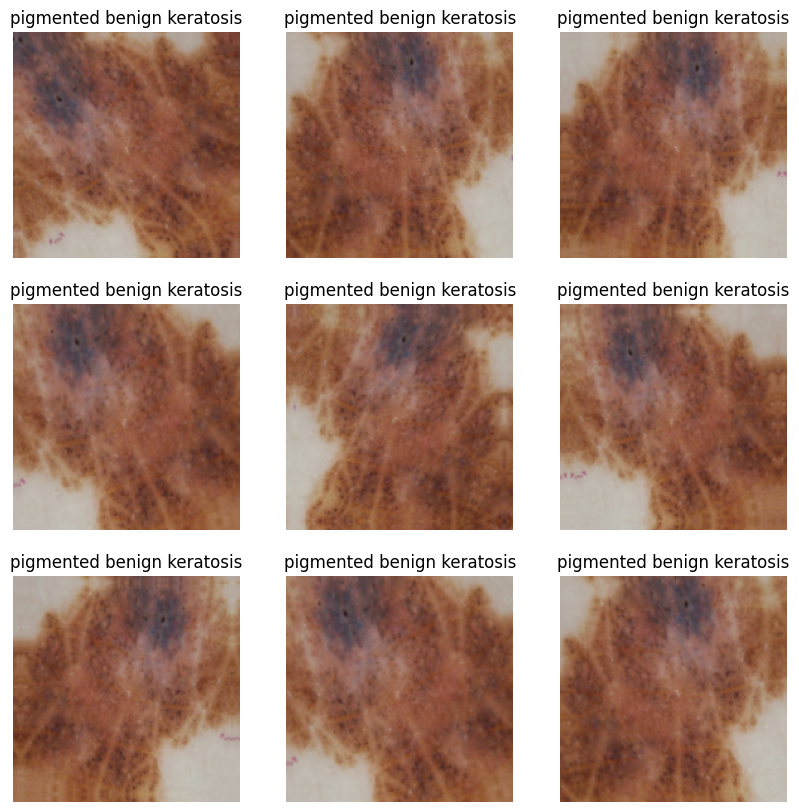

In [ ]:
# Visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

***Observations:***

1. The model's training accuracy shows a steady increase of upto 85%, while validation accuracy remains consistently around 73%.

2. A high training accuracy suggests the model has effectively captured the noise within the data. However, its poor performance on validation data indicates a lack of generalizability.

3. These observations confirm the presence of overfitting. To address this issue, augmentation techniques will be employed. Given the limited training data available, new samples will be generated by making slight modifications to existing data (such as horizontal/vertical image flipping, minor image rotations, etc.), which will then be used for training the model.

### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential([
  augmentation_data,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

### Compiling the model

In [ ]:
## Your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [ ]:
%%time
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
169/169 [==============================] - 240s 1s/step - loss: 1.9770 - accuracy: 0.2754 - val_loss: 1.6432 - val_accuracy: 0.3578
Epoch 2/10
169/169 [==============================] - 238s 1s/step - loss: 1.5210 - accuracy: 0.4095 - val_loss: 1.3883 - val_accuracy: 0.4759
Epoch 3/10
169/169 [==============================] - 238s 1s/step - loss: 1.3800 - accuracy: 0.4674 - val_loss: 1.3660 - val_accuracy: 0.4439
Epoch 4/10
169/169 [==============================] - 238s 1s/step - loss: 1.3106 - accuracy: 0.4961 - val_loss: 1.2916 - val_accuracy: 0.5115
Epoch 5/10
169/169 [==============================] - 237s 1s/step - loss: 1.2195 - accuracy: 0.5256 - val_loss: 1.2010 - val_accuracy: 0.5382
Epoch 6/10
169/169 [==============================] - 238s 1s/step - loss: 1.1953 - accuracy: 0.5365 - val_loss: 1.1282 - val_accuracy: 0.5716
Epoch 7/10
169/169 [==============================] - 237s 1s/step - loss: 1.1798 - accuracy: 0.5482 - val_loss: 1.1614 - val_accuracy: 0.5791

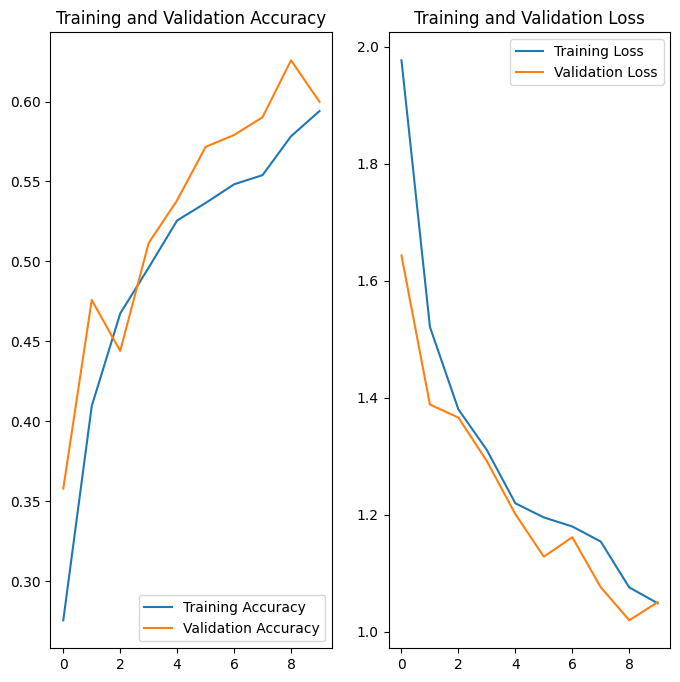

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

***Observations:***

1. By leveraging augmented data, overfitting has been effectively addressed. the training and validation accuracy is around 59 % but accuracy performance drops , suggestive of underfitting

In [ ]:
## Your code goes here.

from glob import glob

## find the image path for all class labels (lesions)
images_path_list = [ i for i in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]

## Extract the class labels (lesions)
lesions_list = [ os.path.basename(os.path.dirname(j)) for j in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesions_list))

2239


In [ ]:
# Extract image path and class label in a dictionary
image_dict = dict(zip(images_path_list, lesions_list))
print(list(image_dict.items())[:5])

[('/content/drive/MyDrive/CNN1/Train/actinic keratosis/ISIC_0030133.jpg', 'actinic keratosis'), ('/content/drive/MyDrive/CNN1/Train/actinic keratosis/ISIC_0027829.jpg', 'actinic keratosis'), ('/content/drive/MyDrive/CNN1/Train/actinic keratosis/ISIC_0025803.jpg', 'actinic keratosis'), ('/content/drive/MyDrive/CNN1/Train/actinic keratosis/ISIC_0029713.jpg', 'actinic keratosis'), ('/content/drive/MyDrive/CNN1/Train/actinic keratosis/ISIC_0028370.jpg', 'actinic keratosis')]


In [ ]:
# View the image path and class label in a df
lesions_df = pd.DataFrame(list(image_dict.items()), columns=['Image Path', 'Label'])
lesions_df.head()

,Image Path,Label
0,/content/drive/MyDrive/CNN1/Train/actinic kera...,actinic keratosis
1,/content/drive/MyDrive/CNN1/Train/actinic kera...,actinic keratosis
2,/content/drive/MyDrive/CNN1/Train/actinic kera...,actinic keratosis
3,/content/drive/MyDrive/CNN1/Train/actinic kera...,actinic keratosis
4,/content/drive/MyDrive/CNN1/Train/actinic kera...,actinic keratosis


In [ ]:
## Inspecting the distribution of classes in the data
lesions_df[['Label']].value_counts()

,count
Label,
pigmented benign keratosis,462
melanoma,438
basal cell carcinoma,376
nevus,357
squamous cell carcinoma,181
vascular lesion,139
actinic keratosis,114
dermatofibroma,95
seborrheic keratosis,77


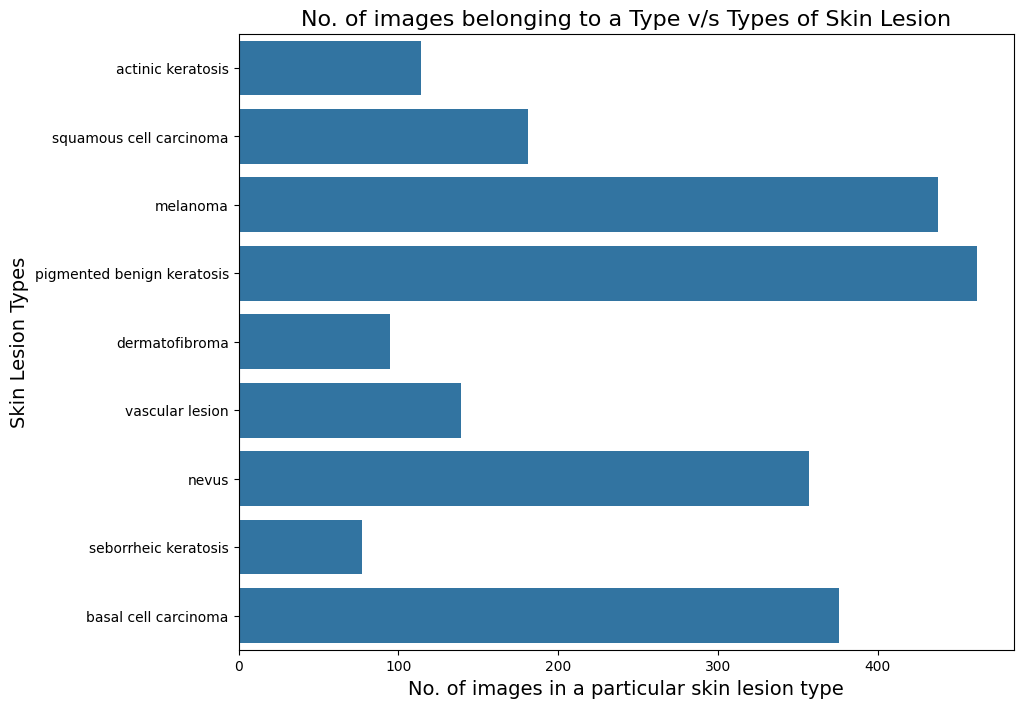

In [ ]:
# Visualize the distribution of classes using a countplot

import seaborn as sns

plt.figure(figsize=(10, 8))
sns.countplot(y="Label", data=lesions_df)
plt.title('No. of images belonging to a Type v/s Types of Skin Lesion', fontsize=16)
plt.xlabel('No. of images in a particular skin lesion type', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.show()

In [ ]:
round(lesions_df[['Label']].value_counts(normalize=True)*100, 2)

,proportion
Label,
pigmented benign keratosis,20.63
melanoma,19.56
basal cell carcinoma,16.79
nevus,15.94
squamous cell carcinoma,8.08
vascular lesion,6.21
actinic keratosis,5.09
dermatofibroma,4.24
seborrheic keratosis,3.44


#### Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


***Observations:***

1. A clear class imbalance is evident within the training data.

2. The class **"seborrheic keratosis"** comprises the smallest proportion of samples, accounting for approximately **3.44%**.

3. **"Pigmented benign keratosis"** and **"melanoma"** significantly outweigh other classes, representing approximately **20.63%** and **19.56%** of the data, respectively.

In [ ]:
!pip install Augmentor

#### Rectify the class imbalance



To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
import Augmentor
import os

path_to_training_dataset = str(data_dir_train) + '/'

for i in class_names:
    # Skip hidden folders like '.ipynb_checkpoints'
    if i.startswith('.'):
        continue
    p = Augmentor.Pipeline(os.path.join(path_to_training_dataset, i)) # Using os.path.join to create correct paths
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/CNN1/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B0127A81050>: 100%|██████████| 500/500 [00:32<00:00, 15.17 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/CNN1/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B0117B71590>: 100%|██████████| 500/500 [00:33<00:00, 14.82 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/CNN1/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B0117B8C350>: 100%|██████████| 500/500 [00:25<00:00, 19.71 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/CNN1/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B0124FB1790>: 100%|██████████| 500/500 [01:43<00:00,  4.84 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/CNN1/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2117x1988 at 0x7B0117FBC890>: 100%|██████████| 500/500 [01:56<00:00,  4.28 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/CNN1/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B0125087290>: 100%|██████████| 500/500 [00:23<00:00, 21.02 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/CNN1/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7B0125087690>: 100%|██████████| 500/500 [00:52<00:00,  9.59 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/CNN1/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B0125086690>: 100%|██████████| 500/500 [00:26<00:00, 19.16 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/CNN1/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B0125067390>: 100%|██████████| 500/500 [00:26<00:00, 19.00 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
# Verifying the total count of images after the augmentation
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
# extracting the augmented image paths in a list
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:5]

['/content/drive/MyDrive/CNN1/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027536.jpg_f3f196f2-183e-4f2f-8d43-262765ccf3a6.jpg',
 '/content/drive/MyDrive/CNN1/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027615.jpg_13b6ea4a-eeca-4d1e-999e-dfae713e7388.jpg',
 '/content/drive/MyDrive/CNN1/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028990.jpg_a4910538-8908-4ef5-8654-12f338dfc198.jpg',
 '/content/drive/MyDrive/CNN1/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027172.jpg_84a1ca47-d6ac-4bfa-931c-d8914a37995c.jpg',
 '/content/drive/MyDrive/CNN1/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0032422.jpg_64799072-836d-45ed-bf13-3eac509d4106.jpg']

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:5]

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [ ]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Image Path','Label'])
# Instead of lesions_df.append(df2), use pd.concat:
new_df = pd.concat([lesions_df, df2], ignore_index=True)
new_df.shape

(11239, 2)

In [ ]:
# View the augmented image paths and labels in a new df
new_df.head()

,Image Path,Label
0,/content/drive/MyDrive/CNN1/Train/actinic kera...,actinic keratosis
1,/content/drive/MyDrive/CNN1/Train/actinic kera...,actinic keratosis
2,/content/drive/MyDrive/CNN1/Train/actinic kera...,actinic keratosis
3,/content/drive/MyDrive/CNN1/Train/actinic kera...,actinic keratosis
4,/content/drive/MyDrive/CNN1/Train/actinic kera...,actinic keratosis


In [ ]:
# Inspecting the classes after adding 500 samples per label
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,1462
melanoma,1438
basal cell carcinoma,1376
nevus,1357
squamous cell carcinoma,1181
vascular lesion,1139
actinic keratosis,1114
dermatofibroma,1095
seborrheic keratosis,1077


In [ ]:
# Inspecting the classes (% age wise) after adding 500 samples per label
round(new_df['Label'].value_counts(normalize=True)*100, 2)

,proportion
Label,
pigmented benign keratosis,13.01
melanoma,12.79
basal cell carcinoma,12.24
nevus,12.07
squamous cell carcinoma,10.51
vascular lesion,10.13
actinic keratosis,9.91
dermatofibroma,9.74
seborrheic keratosis,9.58


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [ ]:
# data_dir_train="path to directory with training data + data created using augmentor"

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


#### Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


#### Create your model (make sure to include normalization)

In [ ]:
## your code goes here

model = Sequential([
  augmentation_data,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

#### Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
# Before compiling the model
# Assuming your original labels start from 1
# Adjust this if your labels start from a different value

def adjust_labels(image, label):
    # Shift labels to start from 0 and ensure they are within the valid range
    adjusted_label = tf.clip_by_value(label - 1, 0, target_labels - 1)
    return image, adjusted_label

train_ds = train_ds.map(adjust_labels)
val_ds = val_ds.map(adjust_labels)

# ... (rest of your code) ...

### Todo, choose an appropriate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### Train your model

In [ ]:
%%time
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
281/281 [==============================] - 631s 2s/step - loss: 1.8948 - accuracy: 0.4133 - val_loss: 8.8035 - val_accuracy: 0.2332
Epoch 2/10
281/281 [==============================] - 614s 2s/step - loss: 1.3115 - accuracy: 0.4875 - val_loss: 1.5927 - val_accuracy: 0.4063
Epoch 3/10
281/281 [==============================] - 568s 2s/step - loss: 1.2290 - accuracy: 0.5023 - val_loss: 1.1933 - val_accuracy: 0.5403
Epoch 4/10
281/281 [==============================] - 619s 2s/step - loss: 1.1531 - accuracy: 0.5410 - val_loss: 1.4533 - val_accuracy: 0.4571
Epoch 5/10
281/281 [==============================] - 613s 2s/step - loss: 1.0772 - accuracy: 0.5686 - val_loss: 2.8193 - val_accuracy: 0.3057
Epoch 6/10
281/281 [==============================] - 615s 2s/step - loss: 1.0279 - accuracy: 0.5903 - val_loss: 1.2495 - val_accuracy: 0.5332
Epoch 7/10
281/281 [==============================] - 621s 2s/step - loss: 1.0012 - accuracy: 0.6004 - val_loss: 1.1682 - val_accuracy: 0.5234

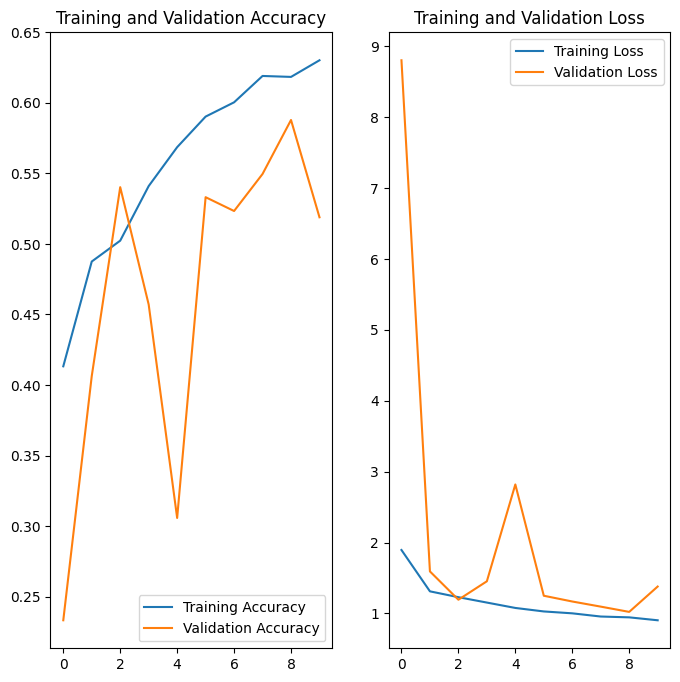

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Creating another model (without batch normalization)

***Observations:***

1. Implementing batch normalization in the model yielded a
downtick in both training and validation accuracy.
2. Formulating an alternative model without batch normalization aims to investigate prospective improvements in accuracy.

In [ ]:
# create the model
model = Sequential([
  augmentation_data,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

#### Compiling the model

In [ ]:
# ipython-input-46-
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# ModelCheckpoint callback is employed alongside the model.fit() training process to periodically save the model
# or its weights (in a checkpoint file)
# Change 'model.keras' to 'model' and add save_format='tf' to use SavedModel format
checkpoint = ModelCheckpoint("model", monitor="val_accuracy", save_best_only=True,
                               mode="auto", verbose=1, save_format='tf')

# Define the EarlyStopping callback
earlystop = EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)

#### Training the model

In [ ]:
%%time
# train the model
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[checkpoint, earlystop]
)

Epoch 1/50
281/281 [==============================] - ETA: 0s - loss: 1.5557 - accuracy: 0.4049
Epoch 1: val_accuracy improved from -inf to 0.48598, saving model to model
281/281 [==============================] - 463s 2s/step - loss: 1.5557 - accuracy: 0.4049 - val_loss: 1.2708 - val_accuracy: 0.4860
Epoch 2/50
281/281 [==============================] - ETA: 0s - loss: 1.2580 - accuracy: 0.5166
Epoch 2: val_accuracy improved from 0.48598 to 0.56742, saving model to model
281/281 [==============================] - 465s 2s/step - loss: 1.2580 - accuracy: 0.5166 - val_loss: 1.1316 - val_accuracy: 0.5674
Epoch 3/50
281/281 [==============================] - ETA: 0s - loss: 1.1679 - accuracy: 0.5494
Epoch 3: val_accuracy improved from 0.56742 to 0.57677, saving model to model
281/281 [==============================] - 466s 2s/step - loss: 1.1679 - accuracy: 0.5494 - val_loss: 1.1195 - val_accuracy: 0.5768
Epoch 4/50
281/281 [==============================] - ETA: 0s - loss: 1.1090 - accura

#### Visualize the model results

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                

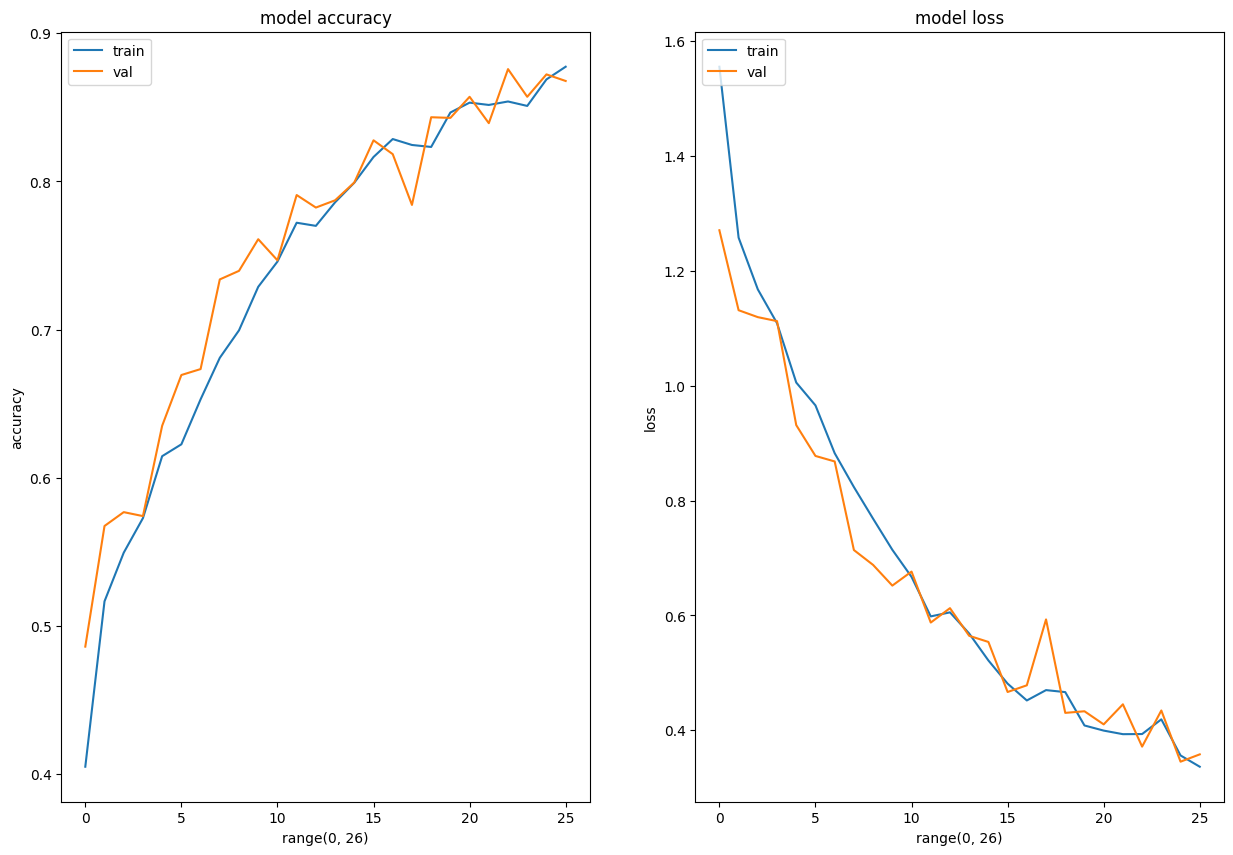

In [ ]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



### Model Evaluation

***Observations:***

1. The ultimate model showcases well-balanced performance, displaying no signs of underfitting or overfitting.

2. The implementation of class rebalancing has notably enhanced the model's performance across both training and validation datasets.

3. Following 26 epochs, the final model attains an accuracy of 87% on the training set and approximately 86% on the validation set.

4. The narrow divergence between training and validation accuracies underscores the robust generalization capability of the final CNN model.

5. The addition of batch normalization failed to enhance both training and validation accuracy.

In [ ]:
# Evaluating our model on one of the instances in the test set

from tensorflow.keras.preprocessing.image import load_img

image_path_test = os.path.join(data_dir_test, class_names[1], '*')
test_image = glob(image_path_test)
test_image = load_img(test_image[-1], target_size=(180, 180, 3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image, axis=0)
predicted = model.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]
print("Actual Class: " + class_names[1] +'\n'+ "Predicted Class: " + predicted_class)